<a href="https://colab.research.google.com/github/cgolfo/cifar10-cnn-classifier-/blob/main/cifar_cnn_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 CNN Classifier with PyTorch

This notebook trains a Convolutional Neural Network to classify images from the CIFAR-10 dataset.

**Dataset:** 60,000 32x32 color images in 10 classes (plane, car, bird, cat, deer, dog, frog, horse, ship, truck)

**Runtime:** Make sure to enable GPU for faster training!
- Go to Runtime → Change runtime type → Hardware accelerator → GPU

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 2. Define CNN Architecture

In [2]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Conv block 1
        x = self.pool(torch.relu(self.conv1(x)))  # 32x32 -> 16x16
        # Conv block 2
        x = self.pool(torch.relu(self.conv2(x)))  # 16x16 -> 8x8
        # Conv block 3
        x = self.pool(torch.relu(self.conv3(x)))  # 8x8 -> 4x4

        # Flatten
        x = x.view(-1, 128 * 4 * 4)

        # Fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Initialize model
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


## 3. Load and Prepare CIFAR-10 Dataset

In [3]:
# Data augmentation for training
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# No augmentation for test
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download and load datasets
print("Downloading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=0)

# Class names
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")

100%|██████████| 170M/170M [00:03<00:00, 49.9MB/s]


Training samples: 50000
Test samples: 10000


## 4. Visualize Sample Images

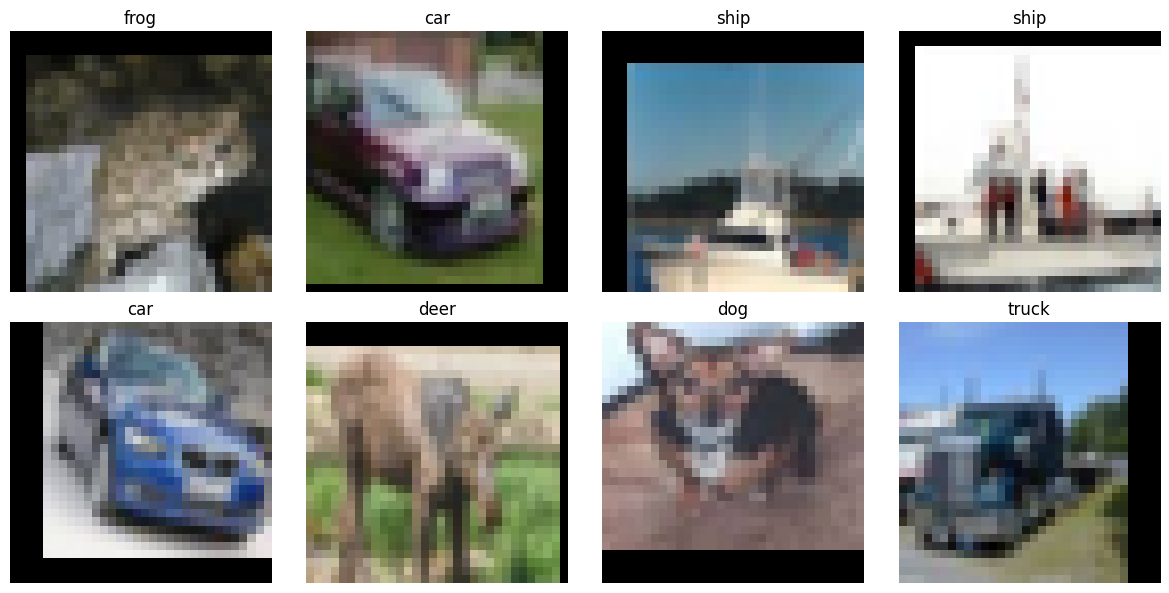

In [4]:
# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Function to show images
def imshow(img):
    img = img / 2 + 0.5  # Denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Show 8 images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)) * 0.5 + 0.5)
    axes[i].set_title(classes[labels[i]])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## 5. Setup Training

In [5]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Setup complete!")
print(f"Optimizer: Adam with lr=0.001")
print(f"Loss function: CrossEntropyLoss")

Setup complete!
Optimizer: Adam with lr=0.001
Loss function: CrossEntropyLoss


## 6. Train the Model

In [6]:
def train_model(epochs=10):
    train_losses = []
    train_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 100 == 99:
                print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], '
                      f'Loss: {running_loss/100:.4f}')
                running_loss = 0.0

        # Epoch statistics
        epoch_acc = 100 * correct / total
        train_accuracies.append(epoch_acc)
        print(f'\nEpoch [{epoch+1}/{epochs}] - Training Accuracy: {epoch_acc:.2f}%\n')

    return train_losses, train_accuracies

# Train the model
print("Starting training...\n")
train_losses, train_accuracies = train_model(epochs=10)
print("\nTraining complete!")

Starting training...

Epoch [1/10], Step [100/782], Loss: 2.0333
Epoch [1/10], Step [200/782], Loss: 1.7685
Epoch [1/10], Step [300/782], Loss: 1.6506
Epoch [1/10], Step [400/782], Loss: 1.5873
Epoch [1/10], Step [500/782], Loss: 1.5249
Epoch [1/10], Step [600/782], Loss: 1.4593
Epoch [1/10], Step [700/782], Loss: 1.4316

Epoch [1/10] - Training Accuracy: 40.54%

Epoch [2/10], Step [100/782], Loss: 1.3905
Epoch [2/10], Step [200/782], Loss: 1.3285
Epoch [2/10], Step [300/782], Loss: 1.3050
Epoch [2/10], Step [400/782], Loss: 1.2403
Epoch [2/10], Step [500/782], Loss: 1.2315
Epoch [2/10], Step [600/782], Loss: 1.1938
Epoch [2/10], Step [700/782], Loss: 1.1670

Epoch [2/10] - Training Accuracy: 54.88%

Epoch [3/10], Step [100/782], Loss: 1.1508
Epoch [3/10], Step [200/782], Loss: 1.1237
Epoch [3/10], Step [300/782], Loss: 1.0966
Epoch [3/10], Step [400/782], Loss: 1.0676
Epoch [3/10], Step [500/782], Loss: 1.0707
Epoch [3/10], Step [600/782], Loss: 1.0430
Epoch [3/10], Step [700/782], Lo

## 7. Evaluate the Model

In [7]:
def evaluate_model():
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Per-class accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    print(f'Overall Test Accuracy: {100 * correct / total:.2f}%\n')

    # Print per-class accuracy
    print('Per-class Accuracy:')
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'  {classes[i]:>10s}: {acc:.2f}%')

evaluate_model()

Overall Test Accuracy: 76.39%

Per-class Accuracy:
       plane: 84.40%
         car: 83.80%
        bird: 68.40%
         cat: 44.10%
        deer: 75.60%
         dog: 75.90%
        frog: 81.20%
       horse: 85.20%
        ship: 81.40%
       truck: 83.90%


## 8. Visualize Predictions

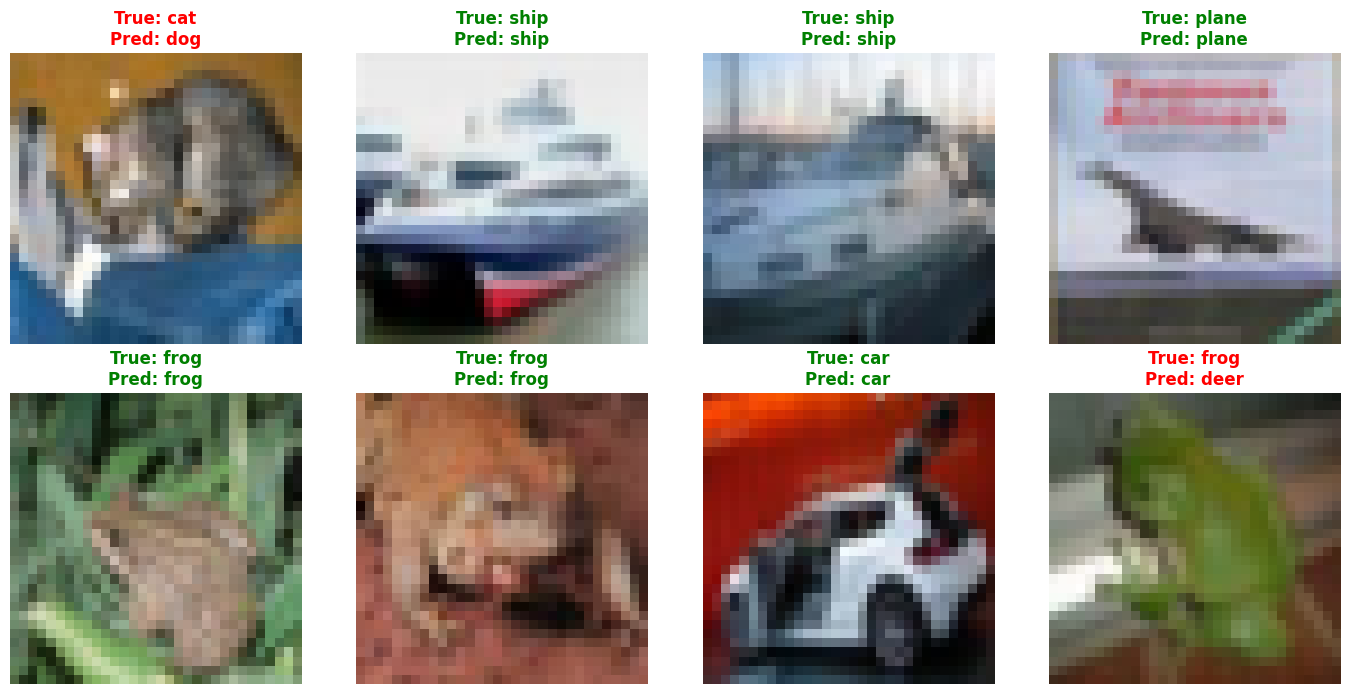

In [8]:
def visualize_predictions(num_images=8):
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Move to CPU for plotting
    images = images.cpu()

    # Plot
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))
    axes = axes.ravel()

    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5  # Denormalize

        axes[i].imshow(img)
        axes[i].set_title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}',
                         color='green' if labels[i] == predicted[i] else 'red',
                         fontsize=12, weight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions()

## 9. Save the Model

In [9]:
# Save the trained model
torch.save(model.state_dict(), 'cifar_cnn_model.pth')
print("Model saved as 'cifar_cnn_model.pth'")

# To download the model in Colab:
# from google.colab import files
# files.download('cifar_cnn_model.pth')

Model saved as 'cifar_cnn_model.pth'


## 10. (Optional) Load Model for Inference

In [ ]:
# To load the model later:
# model = SimpleCNN().to(device)
# model.load_state_dict(torch.load('cifar_cnn_model.pth'))
# model.eval()
# print("Model loaded successfully!")